In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUpPointAttention
from models_adl4cv.loss import get_repulsion_loss4
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches, get_nearest_neighbors_batch_pytorch3d_indicies

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [4]:
NPOINTS = 2048 * 4
CATEGORY = "chair"
BATCH_SIZE = 8 * 3 # 4
PATCH_SIZE = 512

In [5]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='val',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='test',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)4096 (test)4096
Total number of data:662
Min number of points: (train)4096 (test)4096
Total number of data:1317
Min number of points: (train)4096 (test)4096


In [6]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [7]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [8]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [9]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [10]:
def EMD_loss(a,b):
    return EMD(a,b, transpose=False).mean()

In [11]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    emd_loss = EMD_loss(input, output)
    repulsion_loss = get_repulsion_loss4(output, radius=0.5, nsample=200)

    # Same as in https://github.com/yulequan/PU-Net/blob/master/code/model_utils.py
    return 10 * emd_loss + repulsion_loss
    # return 10 * emd_loss + repulsion_loss

In [12]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

In [13]:
def subsample_patches(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,:,idx,:]

In [14]:
model = PVCNNUpPointAttention(num_classes=3, num_shapes=0, extra_feature_channels=0, attention=True, attn_dim=256, up_ratio=2).to("cuda")
model

PVCNNUpPointAttention(
  (point_features): ModuleList(
    (0): PVConv(
      (voxelization): Voxelization(resolution=32)
      (voxel_layers): Sequential(
        (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): Swish()
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): Swish()
        (6): SE3d(
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=8, bias=False)
            (1): Swish()
            (2): Linear(in_features=8, out_features=64, bias=False)
            (3): Sigmoid()
          )
        )
      )
      (point_features): SharedMLP(
        (layers): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): Swish()
        )
      )
    )
    (1): PVConv(
      (vo

In [15]:
noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3))
subsampled_noise = subsample(noise)

print(noise.shape, subsampled_noise.shape)

noise = torch.normal(0, 1, size=(BATCH_SIZE, 4096, 3)).to("cuda")
noise_subsample = subsample(noise)

torch.Size([8, 4096, 3]) torch.Size([8, 2048, 3])


In [25]:
# Random patch
patched_input = get_nearest_neighbors_batch_pytorch3d(noise_subsample, 512).transpose(1,2)

patched_input.shape

torch.Size([8, 3, 512])

In [26]:
patched_input = generate_non_overlapping_patches(noise_subsample).transpose(2,3)
patched_input.shape

torch.Size([4, 8, 3, 512])

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

7929859

In [16]:
output = model(noise_subsample[:10, ...].transpose(1,2)).transpose(1,2)

noise.shape, output.shape

torch.Size([8, 4096, 3, 1])


(torch.Size([8, 4096, 3]), torch.Size([8, 4096, 3]))

In [17]:
emd_loss = EMD_loss(noise, output)
emd_loss

tensor(2.4672, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
from models_adl4cv.patching import generate_patches_spectral

In [81]:
for batch in train_dataloader:
        input = batch["train_points"].to("cuda")
        patched_input = get_nearest_neighbors_batch_pytorch3d(input, (PATCH_SIZE * 2))
        input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
        break

In [15]:
def remove_random_knn_points(patched_input, points_to_remove):
    B, N, C = patched_input.shape
    assert points_to_remove <= N

    _, idx = get_nearest_neighbors_batch_pytorch3d_indicies(patched_input, points_to_remove)

    mask = torch.ones((patched_input.shape[0], patched_input.shape[1]), dtype=torch.bool)
    for i in range(idx.shape[0]):
        mask[i, idx[i]] = False  # Set to False for indices to remove

    filtered_data = patched_input[mask.unsqueeze(-1).repeat(1, 1, patched_input.shape[-1])].view(B, N - points_to_remove, C)

    return filtered_data

In [61]:
augmented_patch = remove_random_knn_points(patched_input, 20)
augmented_patch.shape

torch.Size([16, 1004, 3])

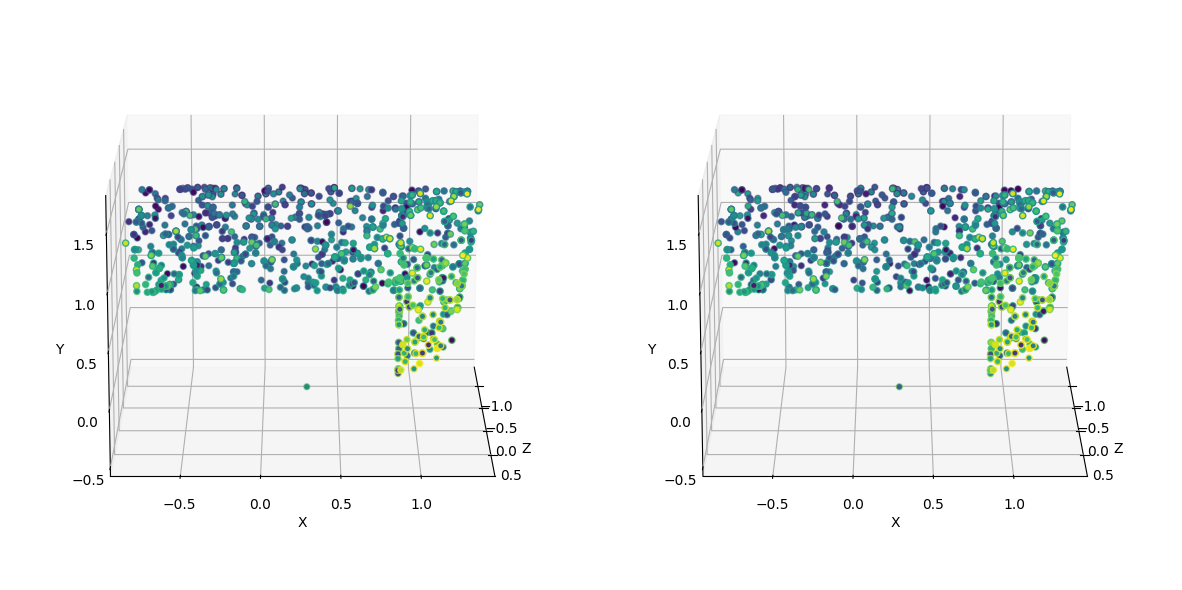

In [64]:
INDEX = 1
fig = visualize_pointcloud_eval(patched_input[INDEX, ...], augmented_patch[INDEX, ...])

In [66]:
from models_adl4cv.patching import random_spectral_patch_batch

patches = random_spectral_patch_batch(input, PATCH_SIZE, k=10)

graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph
graph not connected for 10 increasing it to 20 to connect the graph


In [67]:
patched_input.shape

torch.Size([16, 1024, 3])

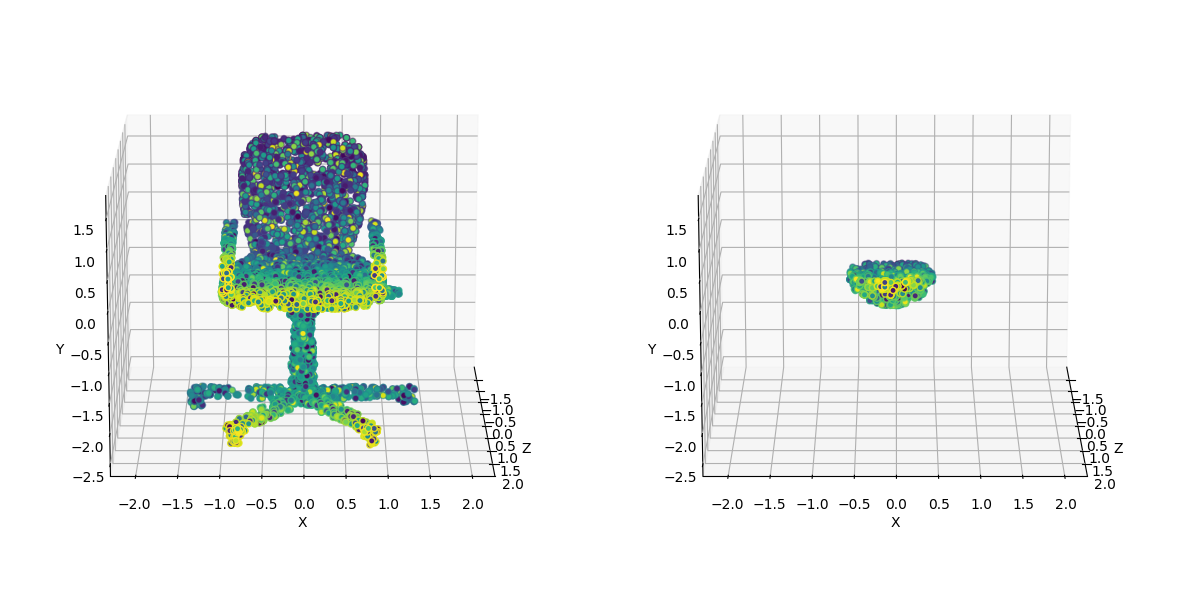

In [86]:
INDEX = 3
fig = visualize_pointcloud_eval(input[INDEX, ...], patched_input[INDEX, ...])

In [15]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-8k-10-to-1'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

LEARNING_RATE_CLIP = 1e-5
DECCAY_STEP = 5
LEARNING_RATE = 3e-4
LEARNING_RATE_DECAY = 0.5

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [ ]:
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0
    
    # Point Transformer Learning Rate Scheduling
    lr = max(LEARNING_RATE * (LEARNING_RATE_DECAY ** (epoch // DECCAY_STEP)), LEARNING_RATE_CLIP)
    print('Learning rate:%f' % lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Train
    model.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/100 Training') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)

            # Data Augmentation - Remove random KNN points. Hopefully, the network
            # will learn to close gaps.
            augmented_patch = remove_random_knn_points(patched_input, 20)

            input_downsampled = subsample(augmented_patch, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            optimizer.zero_grad()
            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            loss = combined_loss(patched_input, output)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            tbar.set_postfix(loss=total_train_loss / (tbar.n + 1))

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Validate
    model.eval()
    with torch.no_grad(), tqdm(val_dataloader, desc=f'Epoch {epoch+1}/100 Validating') as tbar:
        for batch in tbar:
            input = batch["train_points"].to("cuda")

            # Select a random patch with double the size, then downsample, then add noise.
            patched_input = get_nearest_neighbors_batch_pytorch3d(input, PATCH_SIZE * 2)
            input_downsampled = subsample(patched_input, npoints=PATCH_SIZE)
            noised_downsampled_patches = add_random_noise(input_downsampled).transpose(1,2)

            output = model(noised_downsampled_patches).to("cuda").transpose(1,2)

            val_loss = combined_loss(patched_input, output)
            total_val_loss += val_loss.item()
            tbar.set_postfix(loss=total_val_loss / (tbar.n + 1))

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(json.dumps({"Epoch": epoch+1, "Training Loss": epoch_train_loss, "Validation Loss": epoch_val_loss}))

    # Save the model
    model_save_path = f"output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-8k-10-to-1-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break


writer.close()


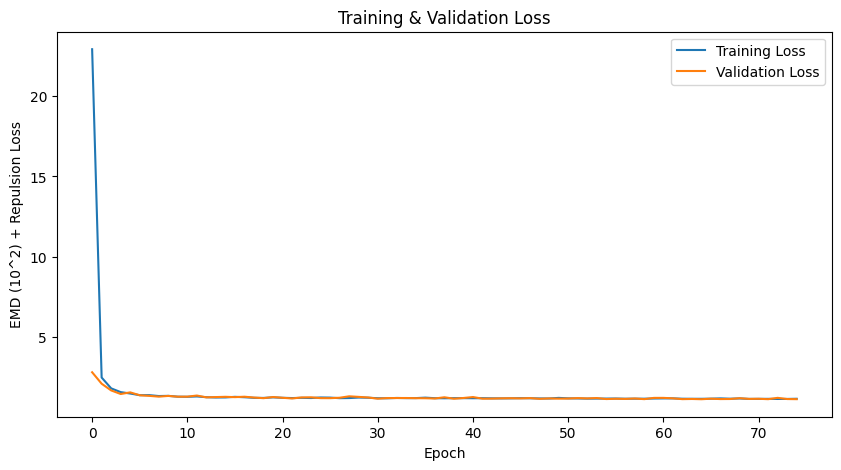

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('EMD (10^2) + Repulsion Loss')
plt.legend()
plt.show()

torch.Size([4096, 3]) torch.Size([512, 3]) torch.Size([1024, 3])


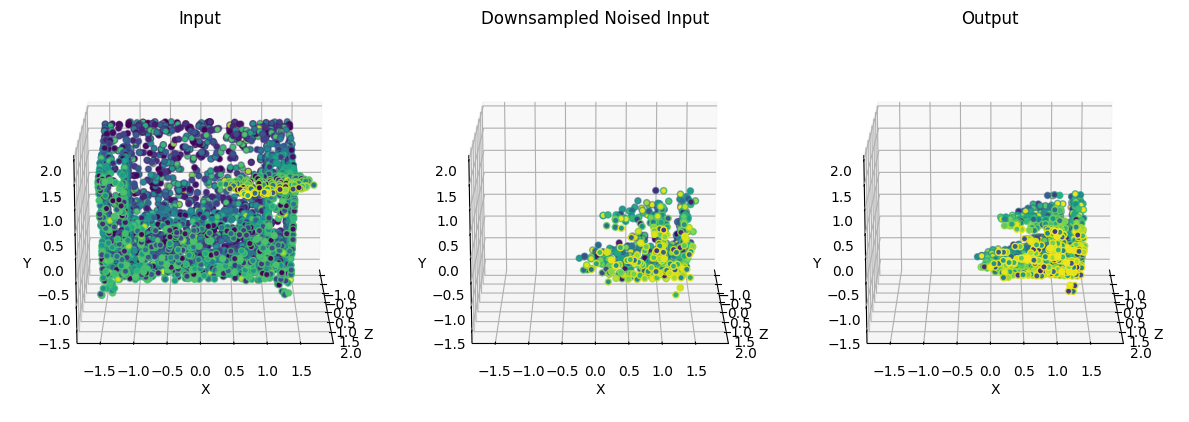

In [75]:
INDEX = 0
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches[INDEX, ...].detach().transpose(0,1)
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's visualize some examples

In [92]:
# Run this if you need to load the model.

model = PVCNNUpPointAttention(num_classes=3, num_shapes=3, extra_feature_channels=0, attention=True, attn_dim=256, up_ratio=3).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-Attention-Everywhere-Patch-6k-e73.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [ ]:
model.eval()

total_test_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        # Select a random patch with double the size, then downsample, then add noise.
        patched_input = generate_non_overlapping_patches(input, PATCH_SIZE * 3)
        input_downsampled = subsample_patches(patched_input, npoints=PATCH_SIZE)
        noised_downsampled_patches = add_random_noise(input_downsampled).transpose(2,3)
        
        refined_patches = []
        for patch in noised_downsampled_patches:
            output = model(patch).to("cuda").transpose(1,2)
            refined_patches.append(output)
        
        output = torch.stack(refined_patches).transpose(0,1).reshape(BATCH_SIZE, NPOINTS, 3)
        
        input_arr.append(input)
        output_arr.append(output)

        loss = combined_loss(input, output)
        total_test_loss += loss.item()
        print(f"Batch {i}, EMD + Repulsion Loss: {loss.item():.4f}")

average_loss = total_test_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

In [45]:
noised_downsampled_patches_comb = noised_downsampled_patches.transpose(0,1).transpose(2,3).reshape(BATCH_SIZE, NPOINTS // 2, 3)
noised_downsampled_patches_comb.shape

torch.Size([32, 2048, 3])

In [ ]:
INDEX = 8
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_patches_comb[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's now try to imrpove the dataset of PVD

In [22]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=[CATEGORY], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

final_val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [23]:
input_array = []

for batch in final_val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [40]:
model.eval()
pvd_input = []

output_array = []
for batch in tqdm(dataloader_pvd):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")
        pvd_input.append(input)
        # Select a random patch with double the size, then downsample, then add noise.
        patched_input = generate_non_overlapping_patches(input, PATCH_SIZE).transpose(2,3)
        refined_patches = []
        for patch in patched_input:
            output = model(patch).to("cuda").transpose(1,2)
            refined_patches.append(output)
        
        output = torch.stack(refined_patches).transpose(0,1).reshape(20, NPOINTS, 3)
        output_array.append(output)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


In [27]:
len(input_array), len(output_array)

(33, 20)

In [41]:
input_pcs = torch.stack(input_array[:20]).view(400, 5000, 3)
pvd_input_pcs = torch.stack(pvd_input).view(400, NPOINTS // 4, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, pvd_input_pcs.shape, output_pcs.shape

(torch.Size([400, 5000, 3]),
 torch.Size([400, 2048, 3]),
 torch.Size([400, 8192, 3]))

In [21]:
num_points_to_select = 5000

# Container for the selected points
selected_points = torch.zeros(output_pcs.size(0), num_points_to_select, output_pcs.size(2))

# Loop through each sample in the batch and select 5000 random points
for i in range(output_pcs.size(0)):
    # Get a random permutation of indices for the current sample's points
    perm = torch.randperm(output_pcs.size(1))
    
    # Select the first 5000 indices from the permutation
    indices = perm[:num_points_to_select]
    
    # Use the selected indices to index into the current sample
    selected_points[i] = output_pcs[i, indices]

In [22]:
selected_points.shape

torch.Size([400, 5000, 3])

In [29]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, selected_points, 50)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  3%|▎         | 12/400 [00:43<23:20,  3.61s/it]

In [ ]:
chair = {
  'lgan_mmd-CD': 0.08294851332902908,
  'lgan_cov-CD': 0.5249999761581421,
  'lgan_mmd_smp-CD': 0.09745326638221741,
  'lgan_mmd-EMD': 0.5428878664970398,
  'lgan_cov-EMD': 0.5450000166893005,
  'lgan_mmd_smp-EMD': 0.596518337726593,
  '1-NN-CD-acc_t': 0.625,
  '1-NN-CD-acc_f': 0.5049999952316284,
  '1-NN-CD-acc': 0.5649999976158142,
  '1-NN-EMD-acc_t': 0.625,
  '1-NN-EMD-acc_f': 0.5525000095367432,
  '1-NN-EMD-acc': 0.5887500047683716
  }

# NNA-CD: 56.49%
# NNA-EMD: 58.87%

torch.Size([2048, 3]) torch.Size([8192, 3])


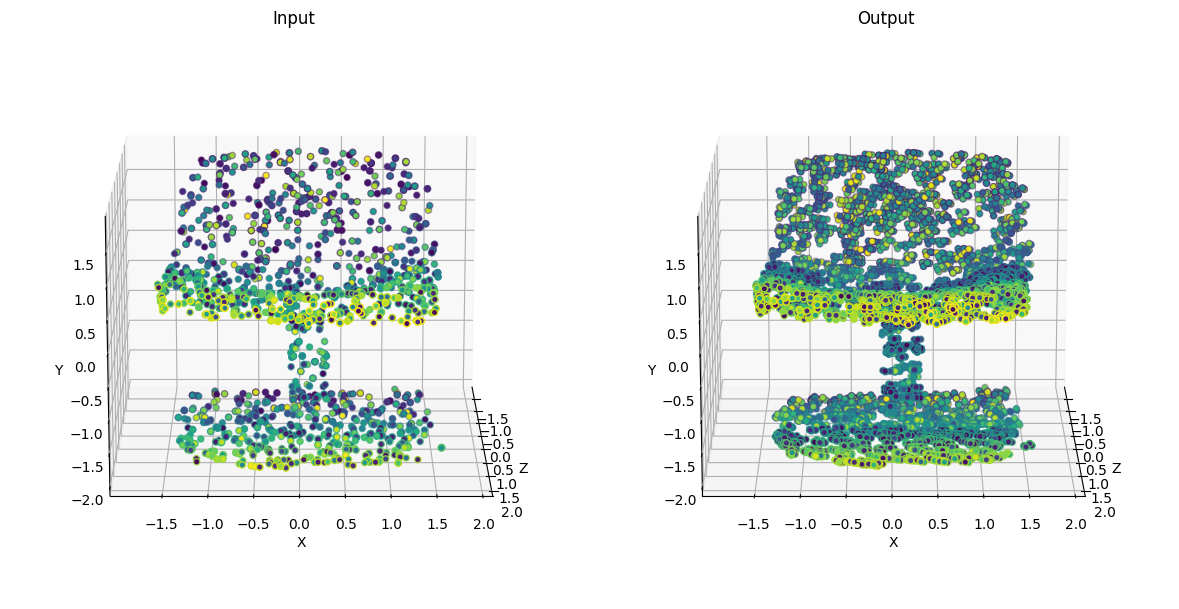

In [61]:
INDEX = 9
input_pc = pvd_input_pcs[INDEX].detach()
output_pc = output_pcs[INDEX].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [40]:
chamfer_distance(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0060, device='cuda:0')

In [41]:
EMD_loss(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0797, device='cuda:0')

In [41]:
test_pc = torch.rand((20, 2048, 3)).to("cuda")
get_repulsion_loss4(test_pc, radius=0.5, nsample=100)

tensor(0.5000, device='cuda:0')

In [42]:
get_repulsion_loss4(output_pc.unsqueeze(0))

tensor(0.0700, device='cuda:0')

In [62]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015, n_points=NPOINTS)

Center: [-0.01962489 -0.0431003  -0.08820915], Scale: 4.008357048034668
Center: [-0.04718602 -0.08851337 -0.10934997], Scale: 4.053016662597656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


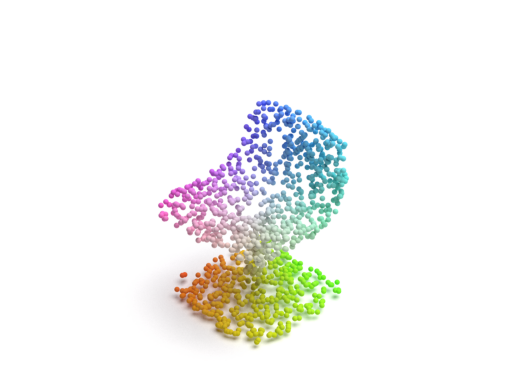

In [63]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


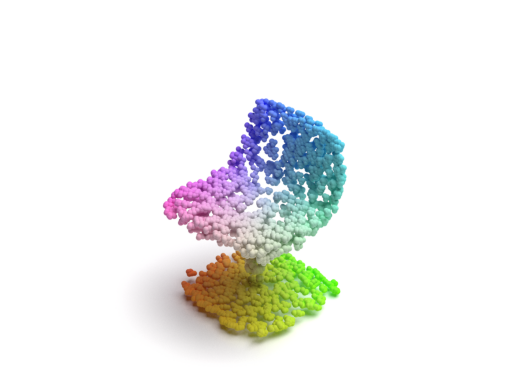

In [64]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

# Let's try part segmentation and then refinement.

In [16]:
from models_adl4cv.pvcnn import PVCNNPartSeg

In [18]:
part_model = PVCNNPartSeg(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-refinement-patch-chair/PVCNN-Baseline-Refinement-Patch-e76.pth"))

<All keys matched successfully>

In [19]:
model.eval()

pvd_output = []
output_array = []

patched_input = []
patched_refined = []

with torch.no_grad():
    for batch in tqdm(dataloader_pvd):
        input = batch["test_points"].to("cuda")
        pvd_output.append(input)

        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        output_batch = []

        for (sample, seg) in zip(input, input_seg):
            output_tensor = []

            for i in range(seg.max() + 1):
                part_input = sample[seg==i, :]
                
                # Patched input
                patched_input.append(part_input)

                output = model(part_input.unsqueeze(0).transpose(1,2))
                output = output.squeeze().transpose(0,1)

                #Refined patch
                patched_refined.append(output)

                output_tensor.append(output)

            output_tensor = torch.cat(output_tensor)
            output_batch.append(output_tensor.unsqueeze(0))
        
        output_batch = torch.cat(output_batch)
        output_array.append(output_batch)

100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


In [ ]:
input_pcs = torch.stack(input_array[:20]).view(400, NPOINTS, 3)
pvd_output_pcs = torch.stack(pvd_output).view(400, NPOINTS // 2, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape, pvd_output_pcs.shape

In [ ]:
INDEX = 14
input_pc = pvd_output_pcs[INDEX, ...].detach()
output_pc = output_pcs[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [44]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=20, radius=0.015)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=20, radius=0.015)

Center: [ 0.02204186 -0.6525706   0.12306881], Scale: 4.433474540710449
Center: [ 0.02340651 -0.6396613   0.14104116], Scale: 4.279245853424072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


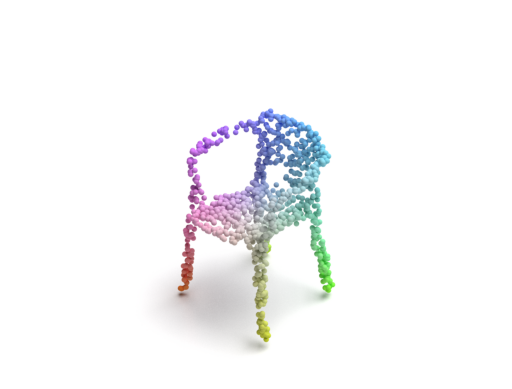

In [45]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)) # approximate sRGB tonemapping
plt.savefig("Input-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


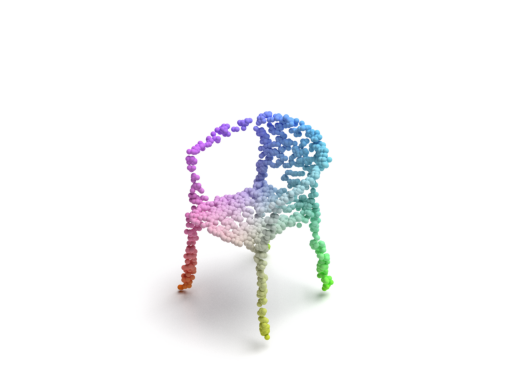

In [46]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("Output-Upsampled-Chair-PVD.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [48]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [14:53<00:00,  2.23s/it]

{'lgan_mmd-CD': 0.08323029428720474, 'lgan_cov-CD': 0.5224999785423279, 'lgan_mmd_smp-CD': 0.097198985517025, 'lgan_mmd-EMD': 0.5473935604095459, 'lgan_cov-EMD': 0.5625, 'lgan_mmd_smp-EMD': 0.5919324159622192, '1-NN-CD-acc_t': 0.6949999928474426, '1-NN-CD-acc_f': 0.5049999952316284, '1-NN-CD-acc': 0.6000000238418579, '1-NN-EMD-acc_t': 0.6349999904632568, '1-NN-EMD-acc_f': 0.5774999856948853, '1-NN-EMD-acc': 0.606249988079071}


In [49]:
torch.save({"results": results} , "chair_part_results.pth")

In [ ]:
import torch
results = torch.load("./chair_part_results.pth")
results

In [ ]:
chair = {
    "lgan_mmd-CD": 0.08323029428720474,
    "lgan_cov-CD": 0.5224999785423279,
    "lgan_mmd_smp-CD": 0.097198985517025,
    "lgan_mmd-EMD": 0.5473935604095459,
    "lgan_cov-EMD": 0.5625,
    "lgan_mmd_smp-EMD": 0.5919324159622192,
    "1-NN-CD-acc_t": 0.6949999928474426,
    "1-NN-CD-acc_f": 0.5049999952316284,
    "1-NN-CD-acc": 0.6000000238418579,
    "1-NN-EMD-acc_t": 0.6349999904632568,
    "1-NN-EMD-acc_f": 0.5774999856948853,
    "1-NN-EMD-acc": 0.606249988079071,
}

# 1-NNA-CD: 60%
# 1-NNA-EMD: 60%